In [1]:
import sys

sys.path.append("..")
from core.DataLoader import (
    DataPreprocessor,
    DataConfig,
    LoadConfig,
    get_load_config_from_yaml,
)
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml

MAX_JETS = 6
PLOTS_DIR = f"plots/compare_model_performance/"
CONFIG_PATH = "../config/workspace_config_HLF.yaml"

import os

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)
plt.rcParams.update({"font.size": 14})

load_config = get_load_config_from_yaml(CONFIG_PATH)

DataProcessor = DataPreprocessor(load_config)
with open(CONFIG_PATH, "r") as f:
    data_config = yaml.safe_load(f)

data_config = DataProcessor.load_from_npz(data_config["data_path"]["nominal"],max_events=200000)
X_train, y_train, X_val, y_val = DataProcessor.split_data(test_size=0.99)

2025-11-26 16:35:07.139605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764171307.162596 4109548 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764171307.169967 4109548 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764171307.187518 4109548 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764171307.187535 4109548 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764171307.187537 4109548 computation_placer.cc:177] computation placer alr

In [2]:
import core.assignment_models as AssignmentModels
import core.evaluation as Evaluation
from core.reconstruction import GroundTruthReconstructor

reload(Evaluation)
reload(AssignmentModels)

ToponiumTransformer = AssignmentModels.FeatureConcatTransformer(data_config, name="ToponiumTransformer")
MODEL_DIR = f"models/toponium_transformer_HLF/"
ToponiumTransformer.load_model(MODEL_DIR + "model.keras")

Transformer = AssignmentModels.FeatureConcatTransformer(data_config, name="Transformer")
MODEL_DIR = f"models/assignment_transformer_HLF/"
Transformer.load_model(MODEL_DIR + "model.keras")

MixedTransformer = AssignmentModels.FeatureConcatTransformer(data_config, name="ToponiumInfusedTransformer")
MODEL_DIR = f"models/mixed_model/"
MixedTransformer.load_model(MODEL_DIR + "model.keras")

FeatureConcatTransformer is designed for classification tasks; regression targets will be ignored.


I0000 00:00:1764171378.324931 4109548 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:65:00.0, compute capability: 6.0


Model loaded from models/toponium_transformer_HLF/model.keras
Training history loaded from models/toponium_transformer_HLF/model_history.npz
FeatureConcatTransformer is designed for classification tasks; regression targets will be ignored.
Model loaded from models/assignment_transformer_HLF/model.keras
Training history loaded from models/assignment_transformer_HLF/model_history.npz
FeatureConcatTransformer is designed for classification tasks; regression targets will be ignored.
Model loaded from models/mixed_model/model.keras


In [3]:
evaluator = Evaluation.ReconstructionEvaluator(
    [
        #AssignmentModels.DeltaRAssigner(data_config),
        #AssignmentModels.ChiSquareAssigner(data_config, top_mass=173.5e3),
        ToponiumTransformer,
        Transformer,
        MixedTransformer,
        GroundTruthReconstructor(data_config, name=r"Perfect Assignment + $\nu^2$-Flows", use_nu_flows=True),
    ],
    X_val,
    y_val,
)

I0000 00:00:1764171383.533828 4110979 service.cc:152] XLA service 0x7f64b00090a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764171383.533856 4110979 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2025-11-26 16:36:23.587608: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert
2025-11-26 16:36:23.614131: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764171383.879694 4110979 cuda_dnn.cc:529] Loaded cuDNN version 91500
I0000 00:00:1764171384.812679 4110979 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-11-26 16:36:29.594802: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring


Computing bootstrap confidence intervals...
ToponiumTransformer: 0.2381 [0.2362, 0.2397]
Transformer: 0.7949 [0.7927, 0.7967]
ToponiumInfusedTransformer: 0.7736 [0.7721, 0.7753]
Perfect Assignment + $\nu^2$-Flows: Ground Truth (skipping)


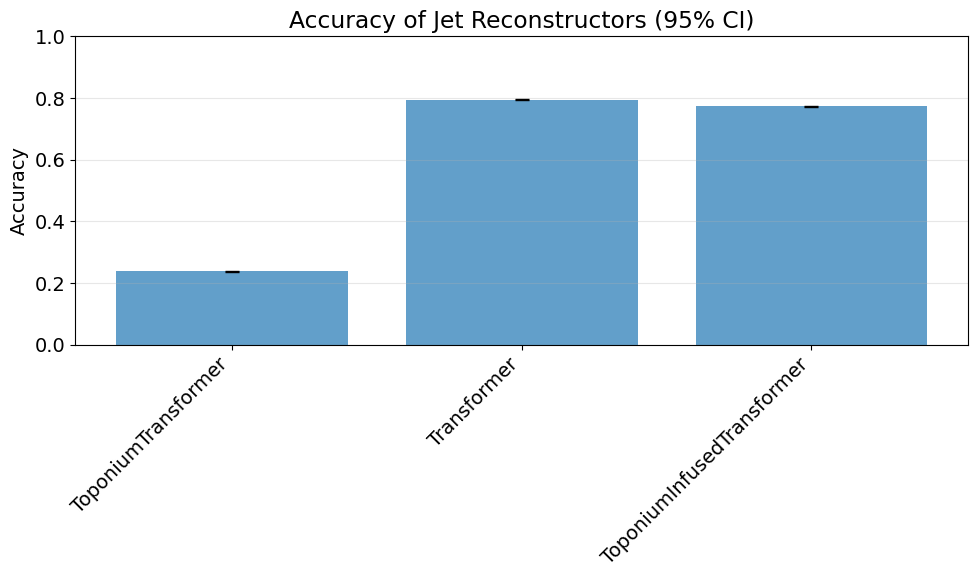

In [4]:
fig, ax = evaluator.plot_all_accuracies()
fig.savefig(PLOTS_DIR + "all_accuracies.pdf")


Computing bootstrap confidence intervals...
ToponiumTransformer: 0.8585 [0.8572, 0.8597]
Transformer: 0.9518 [0.9508, 0.9527]
ToponiumInfusedTransformer: 0.9549 [0.9539, 0.9558]
Perfect Assignment + $\nu^2$-Flows: Ground Truth (skipping)


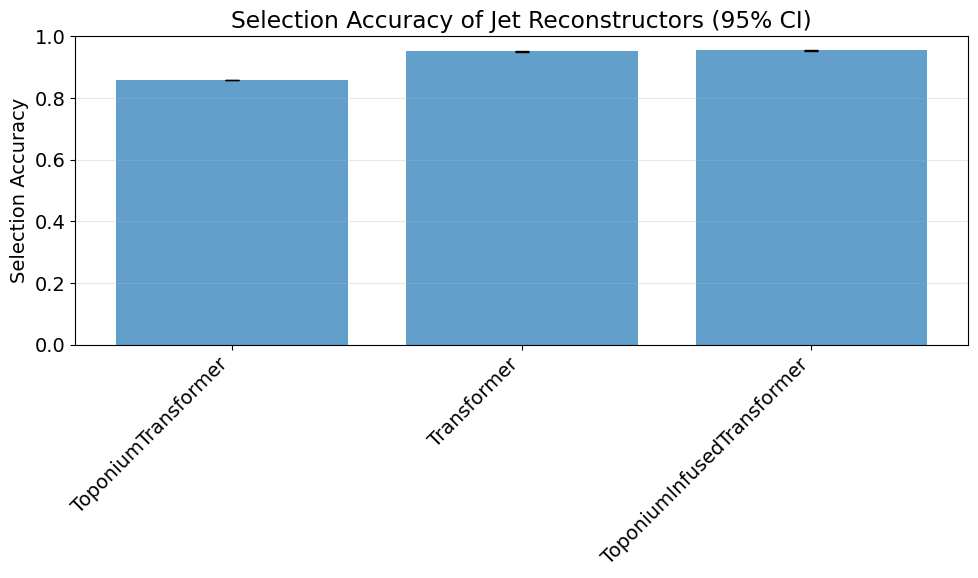

In [5]:
fig, ax = evaluator.plot_all_selection_accuracies()
fig.savefig(PLOTS_DIR + "all_selection_accuracies.pdf")


Computing binned accuracy for truth_ttbar_mass...


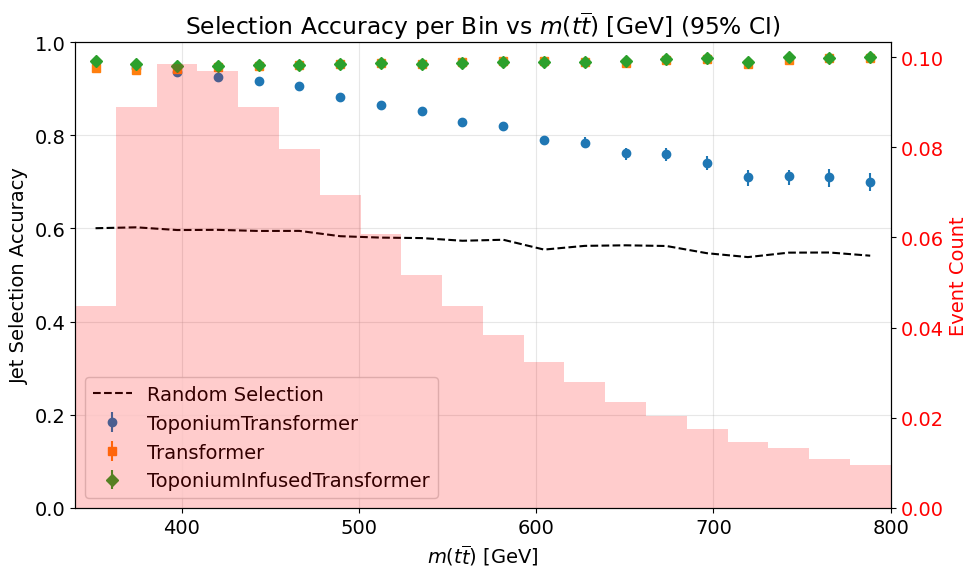

In [6]:
fig, ax = evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)

fig.savefig(PLOTS_DIR + "binned_selecton_accuracy_ttbar_mass_comparison.pdf")

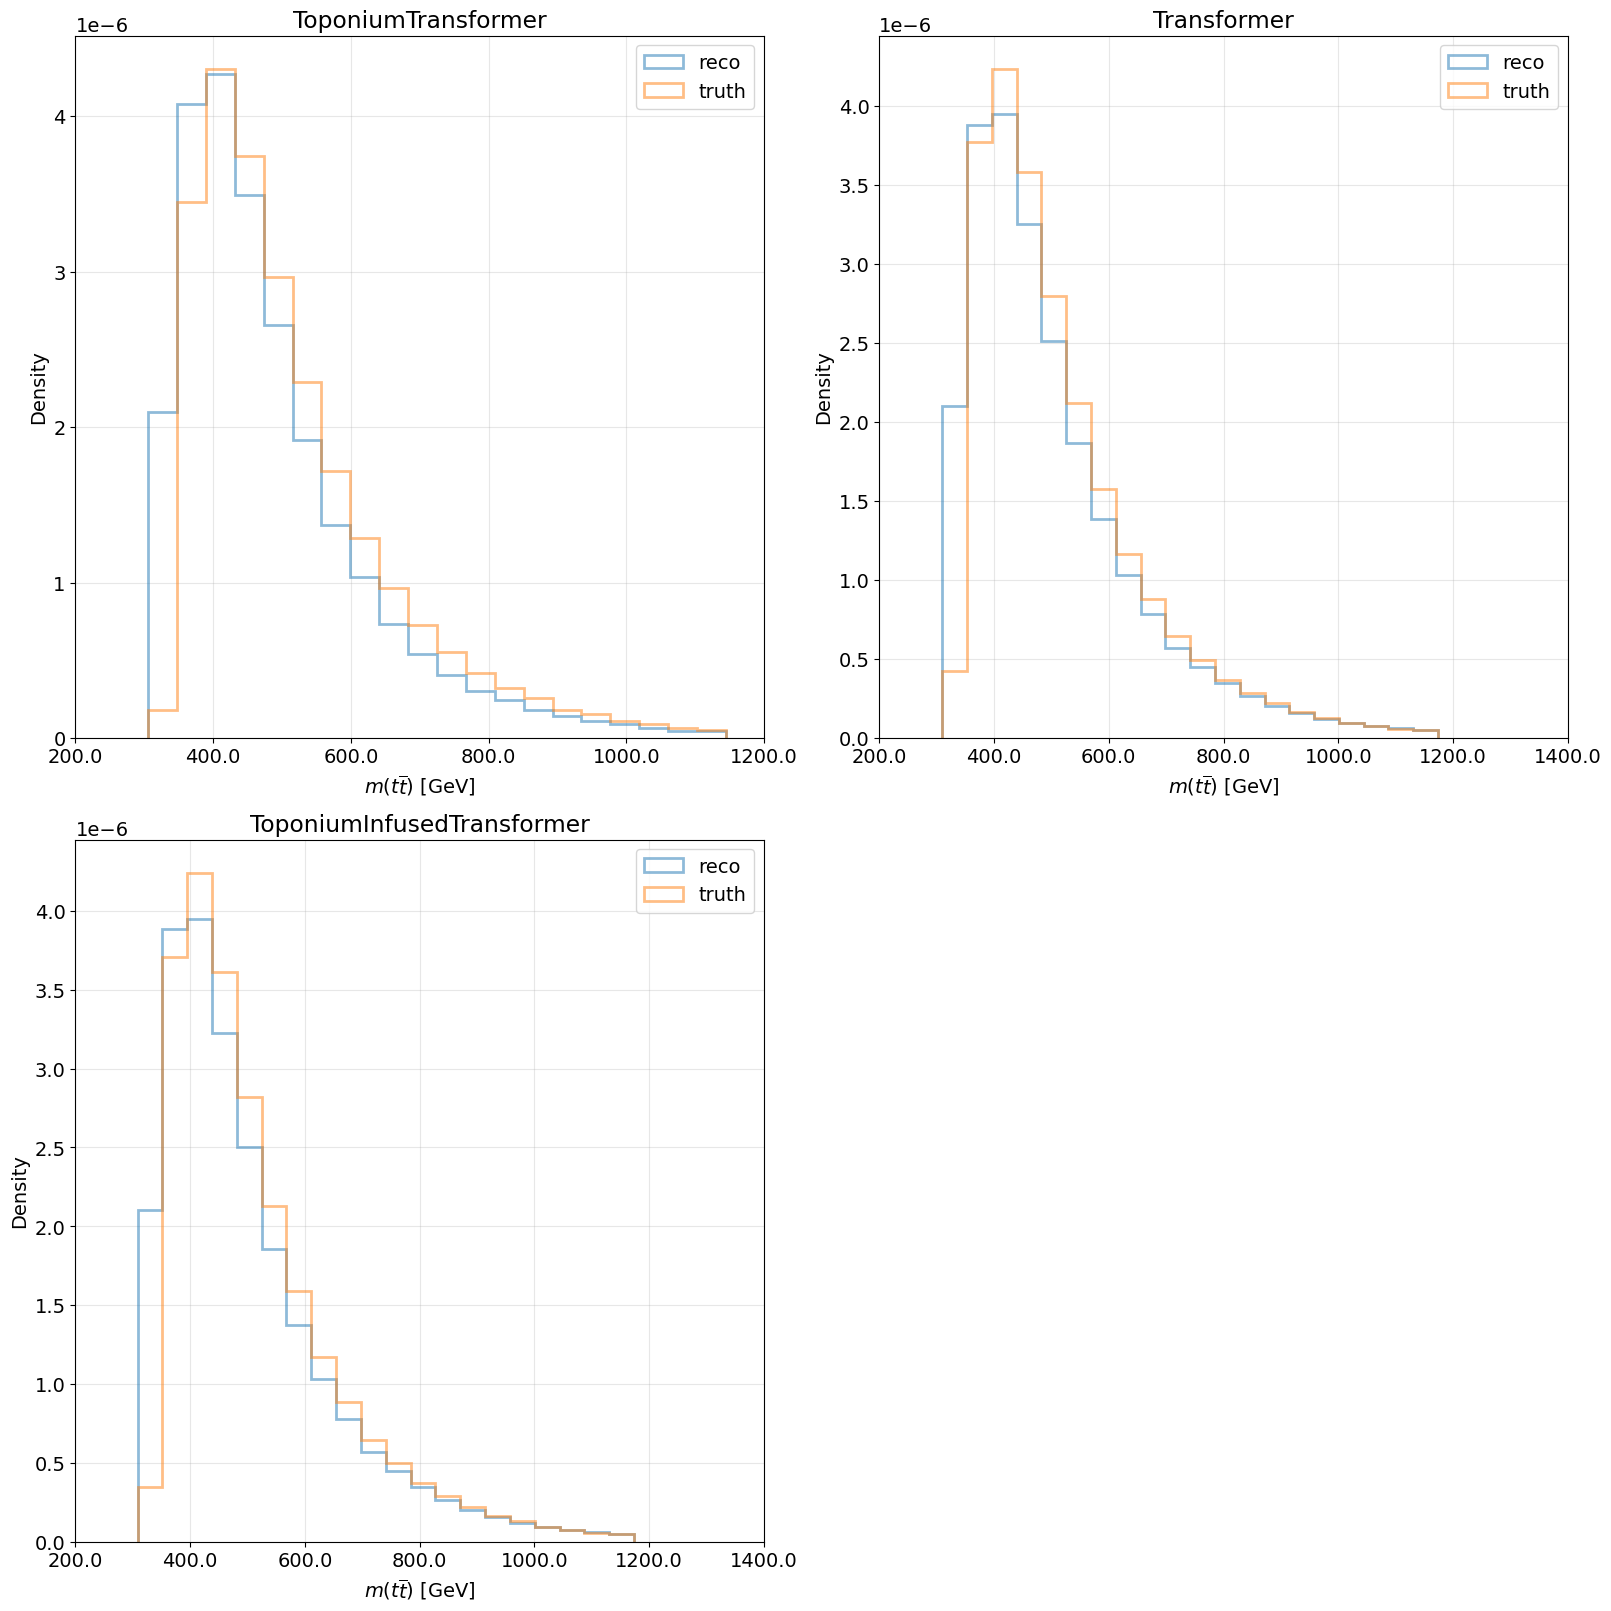

In [7]:
fig, ax = evaluator.plot_ttbar_mass_distributions(bins = 20, figsize=(16,16))
fig.savefig(f"{PLOTS_DIR}/ttbar_mass_distributions.png", bbox_inches="tight")

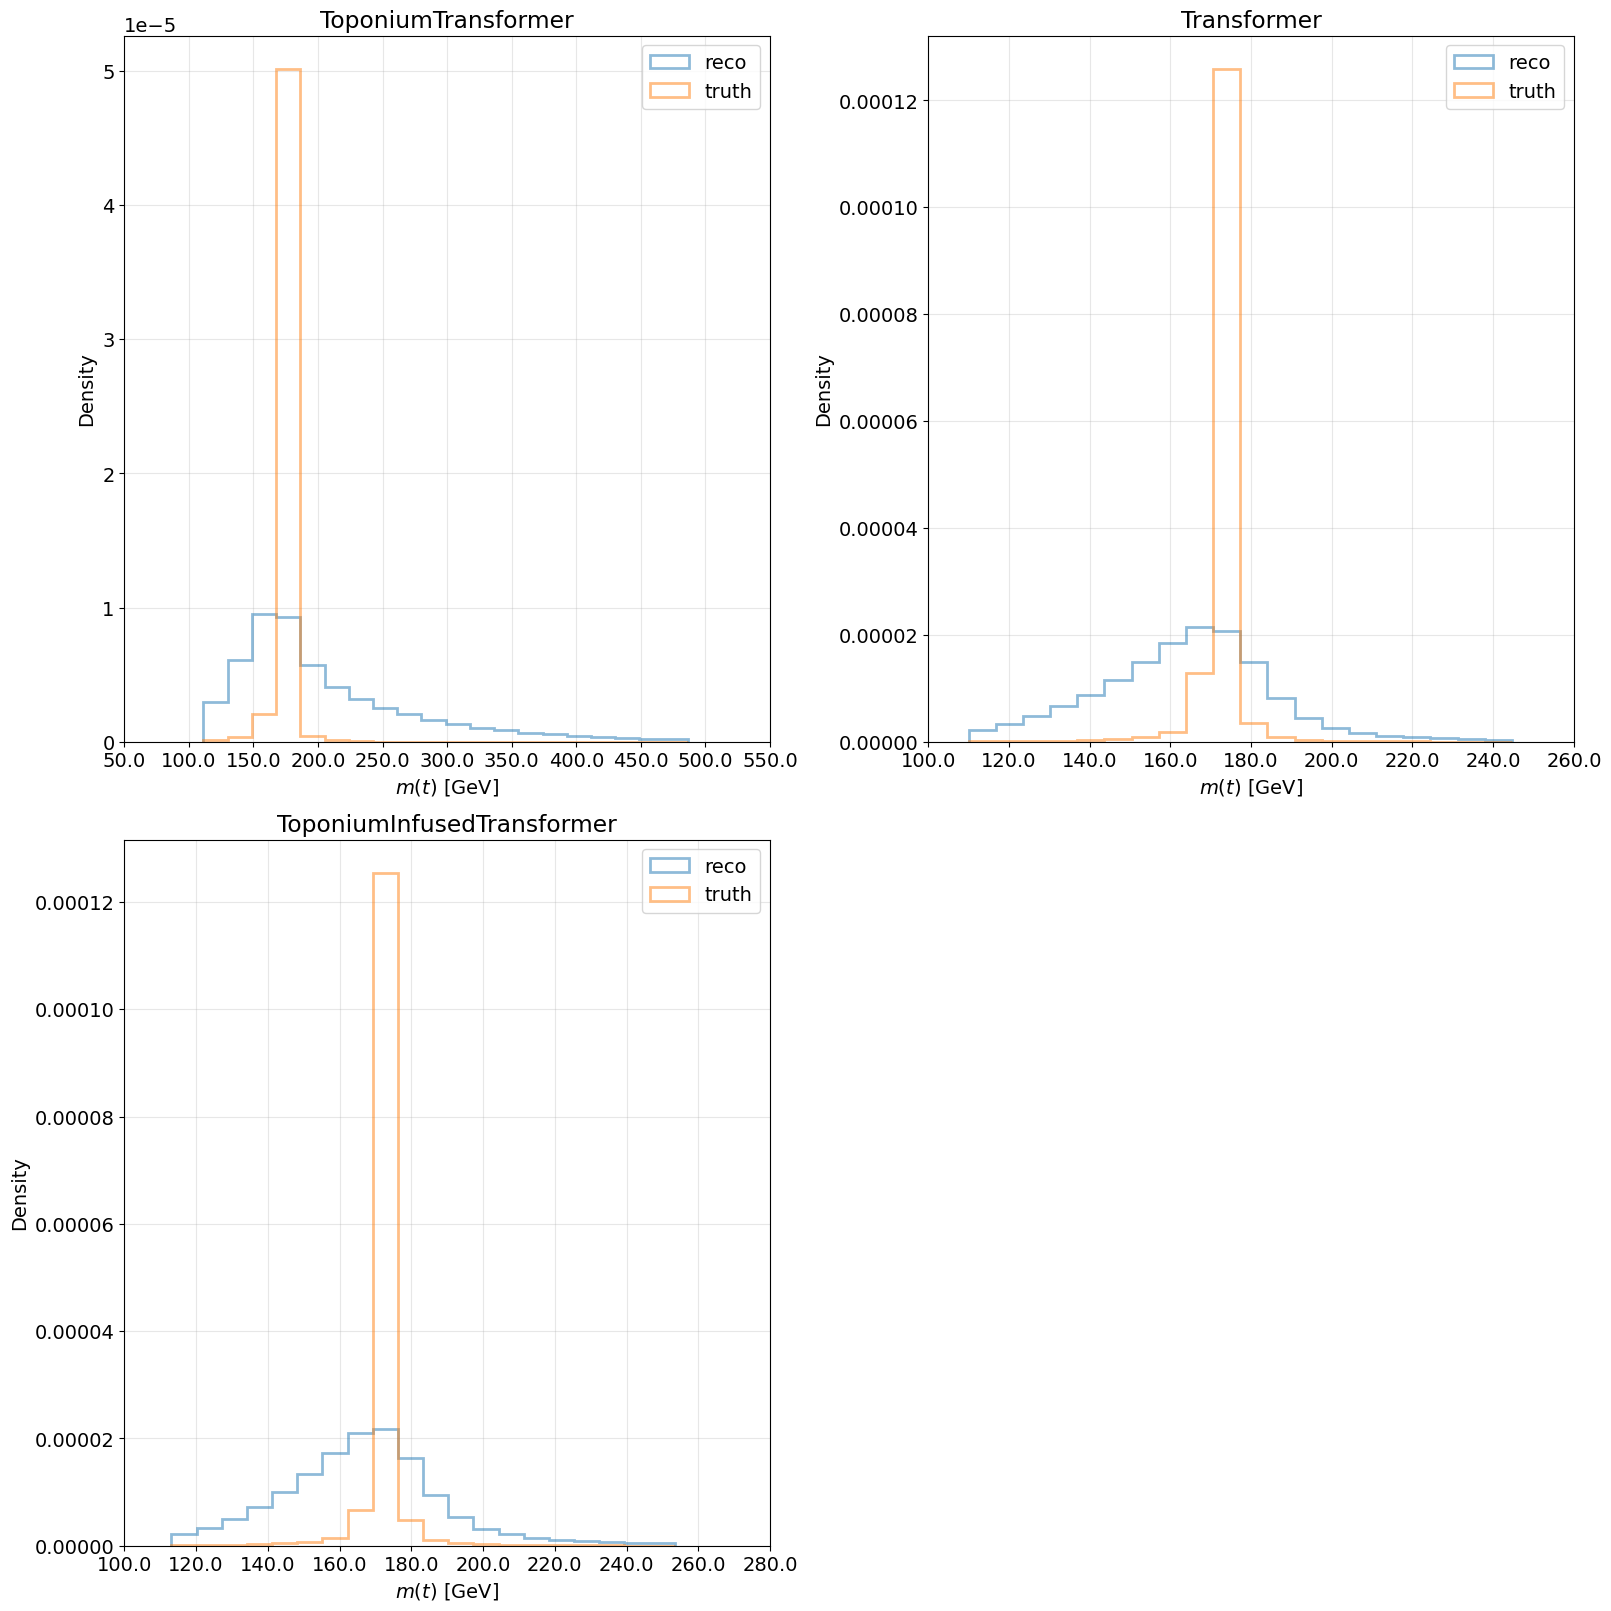

In [8]:
fig, ax = evaluator.plot_top_mass_distributions(bins = 20, figsize=(16,16))
fig.savefig(f"{PLOTS_DIR}/top_mass_distributions.png", bbox_inches="tight")

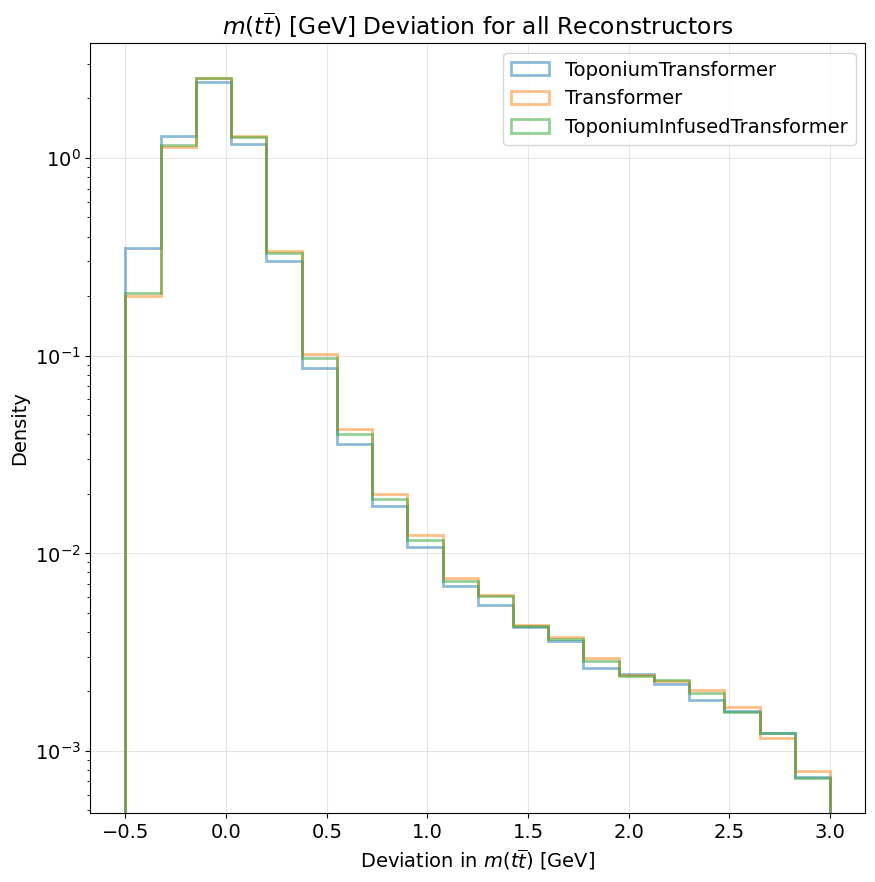

In [9]:
fig, ax = evaluator.plot_ttbar_mass_deviation_distribution(bins = 20, xlims = (-0.5, 3))
ax.set_yscale("log")
fig.savefig(f"{PLOTS_DIR}/ttbar_mass_deviation_distribution.png", bbox_inches="tight")

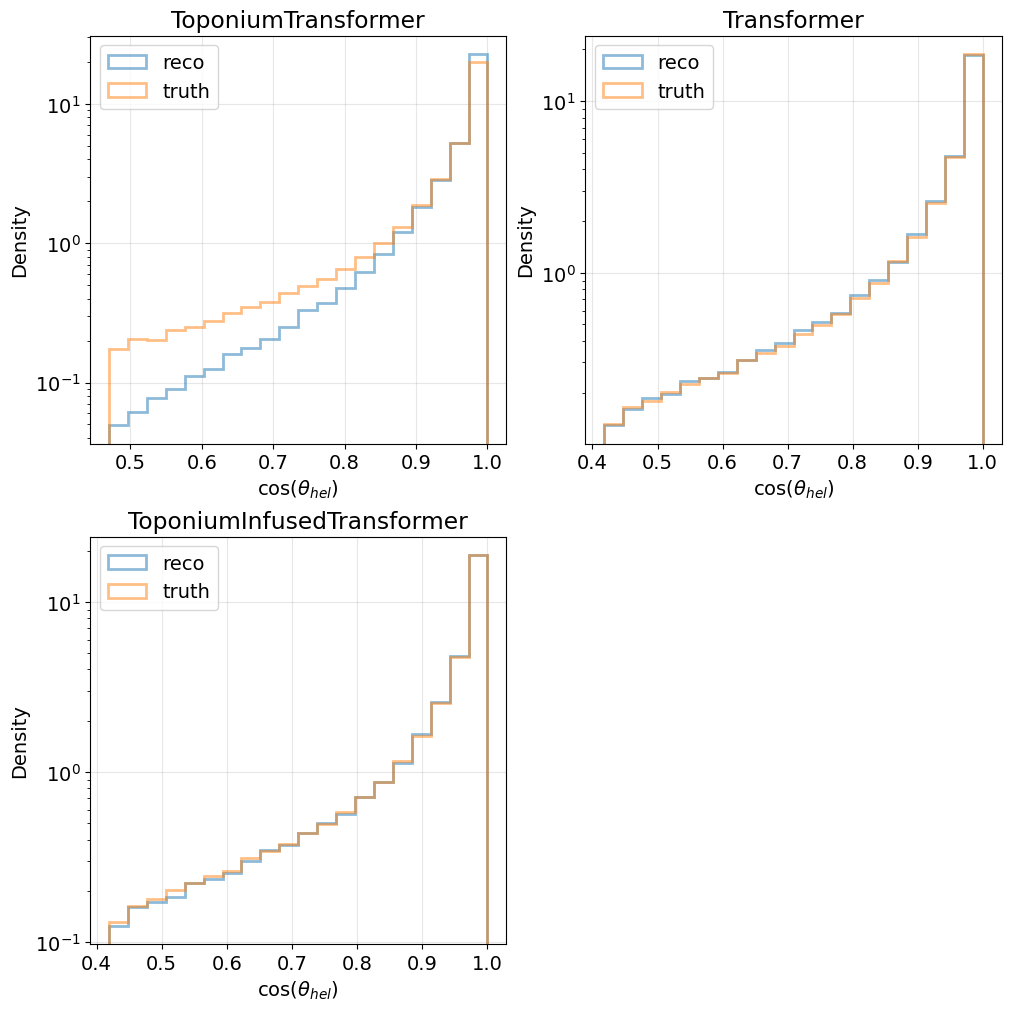

In [10]:
fig, axes = evaluator.plot_c_hel_distributions(bins = 20)
for ax in axes:
    ax.set_yscale("log")
fig.savefig(f"{PLOTS_DIR}/c_hel_distributions.png", bbox_inches="tight")

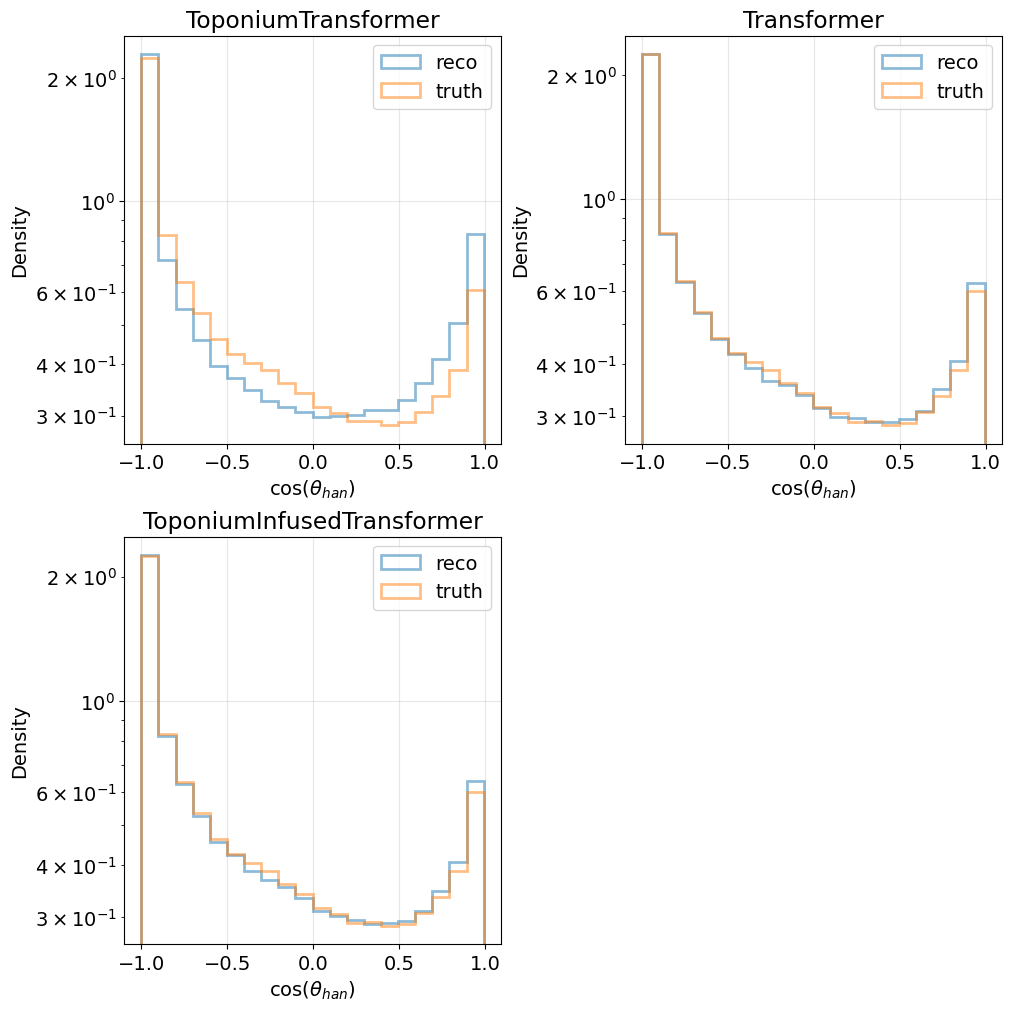

In [11]:
fig, axes = evaluator.plot_c_han_distributions(bins = 20)
for ax in axes:
    ax.set_yscale("log")
fig.savefig(f"{PLOTS_DIR}/c_han_distributions.png", bbox_inches="tight")

## Resolution Plots


Computing binned $\cos(\theta_{hel})$ Resolution for truth_ttbar_mass...


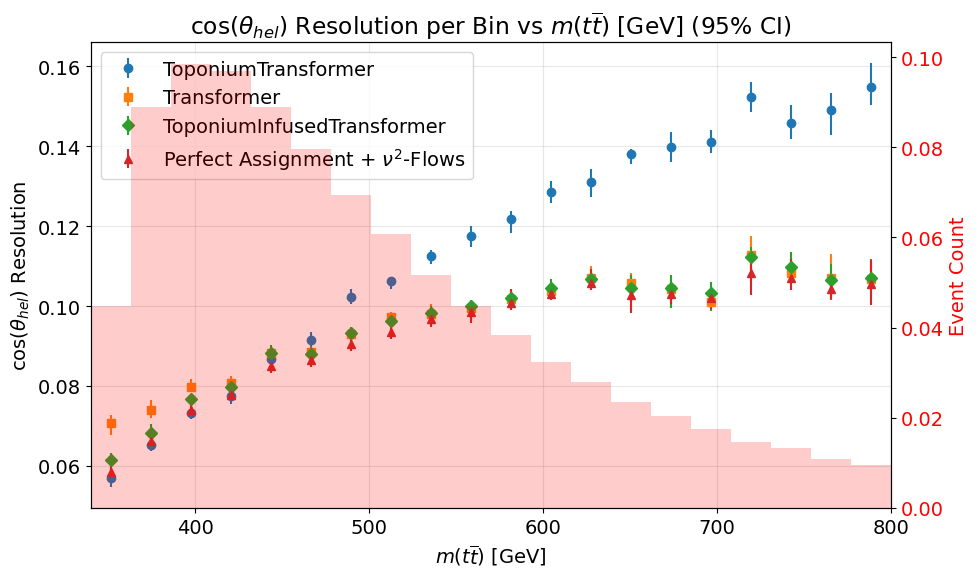

In [12]:
fig, ax = evaluator.plot_binned_c_hel_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "c_hel_resolution_comparison.pdf")


Computing binned $\cos(\theta_{han})$ Resolution for truth_ttbar_mass...


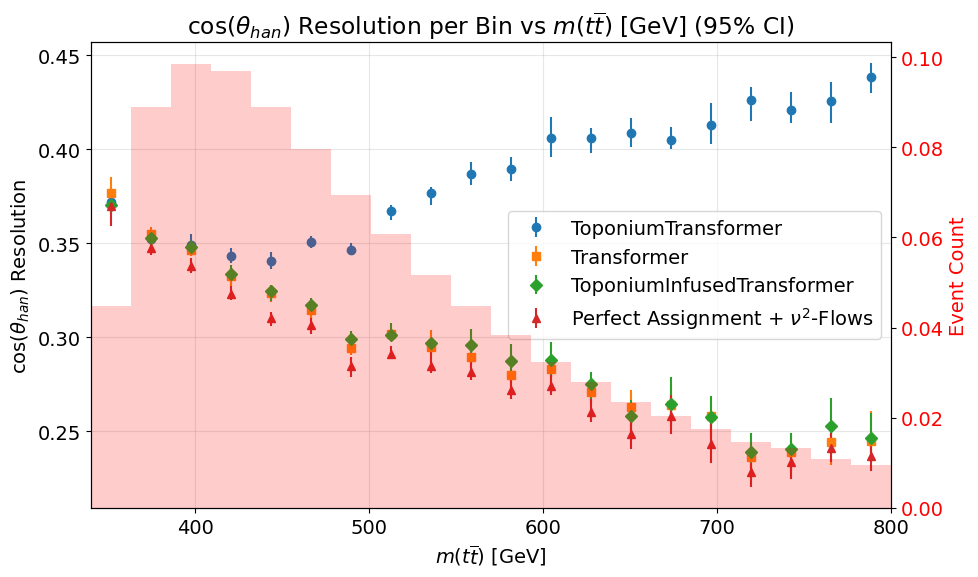

In [13]:
fig, ax = evaluator.plot_binned_c_han_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "c_han_resolution_comparison.pdf")


Computing binned Relative $m(t\overline{t})$ Resolution for truth_ttbar_mass...


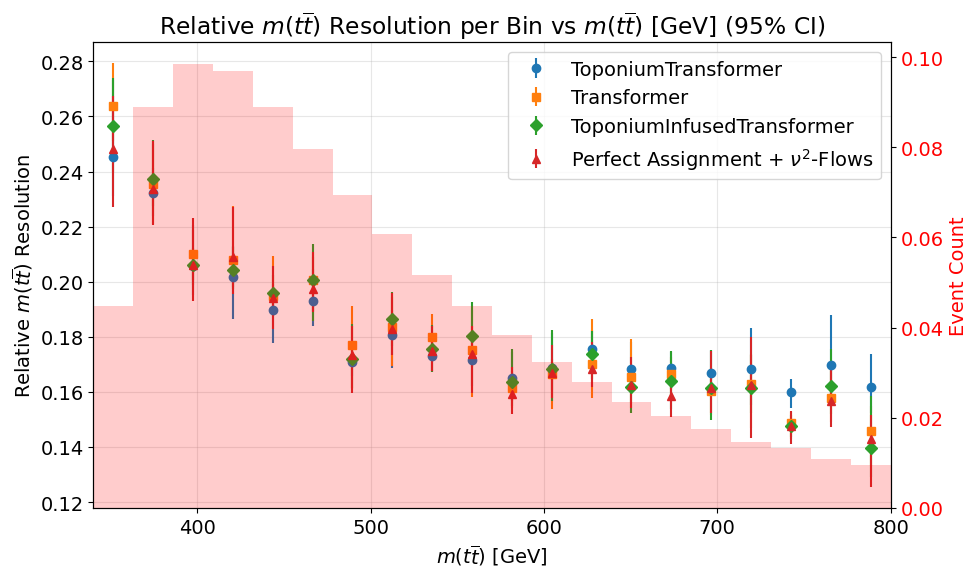

In [14]:
fig, ax = evaluator.plot_binned_ttbar_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "ttbar_mass_resolution_comparison.pdf")


Computing bootstrap confidence intervals...
ToponiumTransformer: 0.2376 [0.2361, 0.2395]
Transformer: 0.7954 [0.7935, 0.7970]
ToponiumInfusedTransformer: 0.7734 [0.7722, 0.7750]
Perfect Assignment + $\nu^2$-Flows: Ground Truth (skipping)


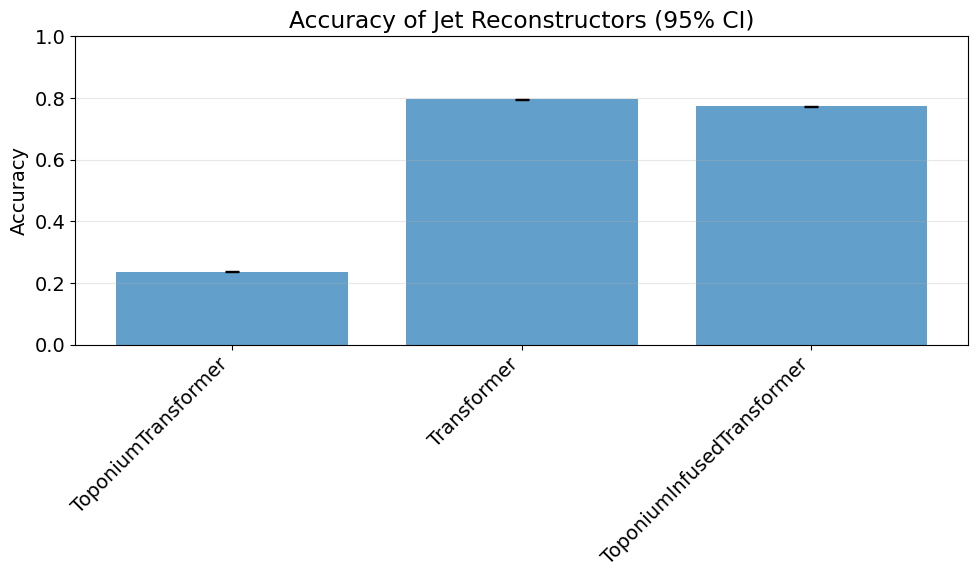

In [15]:
fig, ax = evaluator.plot_all_accuracies(
    n_bootstrap=10
)
fig.savefig(PLOTS_DIR + "all_accuracies.pdf")

## Accuracy Plots

In [16]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, data_configs["LoadConfig"]["max_jets"] + 1),
    bins=data_configs["LoadConfig"]["max_jets"] - 1,
    n_bootstrap=10,
)
ax.set_xticks([i + 0.5 for i in range(2, data_configs["LoadConfig"]["max_jets"] + 1)])
ax.set_xticklabels([i for i in range(2, data_configs["LoadConfig"]["max_jets"] + 1)])
fig.savefig(PLOTS_DIR + "binned_accuracy_N_jets.pdf")

NameError: name 'data_configs' is not defined

In [ ]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_mass.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_pt",
    fancy_feature_label=r"$p_T(t\overline{t})$ [GeV]",
    xlims=(0, 400e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(0, 400e3)

fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_pT.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_top_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "top_mass_resolution_comparison.pdf")

## Mass Resolution and Deviation Plots

In [ ]:
fig, ax = evaluator.plot_binned_top_mass_deviation(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.axhline(0, color="black", linestyle="--")
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "top_mass_deviation_comparison.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_ttbar_mass_deviation(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "ttbar_mass_deviation_comparison.pdf")

In [ ]:
evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    n_bootstrap=10,
    xlims=(340e3, 800e3),
)
fig.savefig(PLOTS_DIR + "binned_selection_accuracy_ttbar_mass.pdf")

## Confusion Matrices and Complementarity

In [ ]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
    n_bootstrap=10,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_accuracy_initial_state.pdf")

In [ ]:
fig, ax = evaluator.plot_confusion_matrices()
fig.savefig(PLOTS_DIR + "confusion_matrices.pdf")